In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
from __future__ import print_function
import argparse
import os

import numpy as np
import pickle

from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Flatten, Dense, Dropout
from keras.layers import merge
from keras.optimizers import Adam, SGD, RMSprop
from keras.preprocessing.image import list_pictures, array_to_img

from image_ext import list_pictures_in_multidir, load_imgs_asarray
from create_fcn import create_fcn01, create_pupil_net00
from fname_func import load_fnames, make_fnames

np.random.seed(2016)

/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/nakazawa_atsushi/anaconda3/envs/py3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def get_center(im):
    im[im>0] = 1;
    xval = 0
    yval = 0
    npix = 0

    for x in range(0,im.shape[1]):
        xval += (x*sum(im[:,x]))
        npix += sum(im[:,x])
    
    for y in range(0,im.shape[0]):
        yval += (y*sum(im[y,:]))
    
    return [xval/npix,yval/npix]

In [3]:
#
#  MAIN STARTS FROM HERE
#
if __name__ == '__main__':
    
    target_size = (224, 224)
    dpath_this = './'
    dname_checkpoints = 'checkpoints_pupil_net00'
    dname_checkpoints_fcn01 = 'checkpoints_fcn01'
    fname_architecture = 'architecture.json'
    fname_weights = "model_weights_{epoch:02d}.h5"
    fname_stats = 'stats01.npz'
    dim_ordering = 'channels_first'
    fname_history = "history.pkl"

    # モデルを作成
    print('creating model...')
    model_pupil_net = create_pupil_net00(target_size)
    
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)    

creating model...


In [4]:
    # Read Learning Data
    #fnames = load_fnames('data_augumented/list_train_01.txt')
    #[fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')
    fnames = load_fnames('data/list_train_01.txt')
    [fpaths_xs_train,fpaths_ys_train] = make_fnames(fnames,'data/img','data/mask','OperatorA_')

    X_train = load_imgs_asarray(fpaths_xs_train, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_train = load_imgs_asarray(fpaths_ys_train, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering) 

    # Read Validation Data
    #fnames = load_fnames('data_augumented/list_valid_01.txt')
    #[fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data_augumented/img','data_augumented/mask','')
    fnames = load_fnames('data/list_valid_01.txt')
    [fpaths_xs_valid,fpaths_ys_valid] = make_fnames(fnames,'data/img','data/mask','OperatorA_')
    
    print('reading validation data')
    X_valid = load_imgs_asarray(fpaths_xs_valid, grayscale=False, target_size=target_size,
                                dim_ordering=dim_ordering)
    Y_valid = load_imgs_asarray(fpaths_ys_valid, grayscale=True, target_size=target_size,
                                dim_ordering=dim_ordering)      

    # obtain center of pupil
    center_train = []
    center_valid = []
    
    for i in range(Y_train.shape[0]):
        center_train.append(get_center(Y_train[i,0,:,:]))

    for i in range(Y_valid.shape[0]):
        center_valid.append(get_center(Y_valid[i,0,:,:]))
    
    center_train = np.array(center_train)
    center_valid = np.array(center_valid)

    print('==> ' + str(len(X_train)) + ' training images loaded')
    print('==> ' + str(len(Y_train)) + ' training masks loaded')
    print('==> ' + str(len(X_valid)) + ' validation images loaded')
    print('==> ' + str(len(Y_valid)) + ' validation masks loaded')

    # 前処理
    print('computing mean and standard deviation...')
    mean = np.mean(X_train, axis=(0, 2, 3))
    std = np.std(X_train, axis=(0, 2, 3))
    print('==> mean: ' + str(mean))
    print('==> std : ' + str(std))

    print('saving mean and standard deviation to ' + fname_stats + '...')
    stats = {'mean': mean, 'std': std}
    if os.path.exists(dname_checkpoints) == 0:
        os.mkdir(dname_checkpoints)
    np.savez(dname_checkpoints + '/' + fname_stats, **stats)
    print('==> done')

    print('globally normalizing data...')
    for i in range(3):
        X_train[:, i] = (X_train[:, i] - mean[i]) / std[i]
        X_valid[:, i] = (X_valid[:, i] - mean[i]) / std[i]
    Y_train /= 255
    Y_valid /= 255
    print('==> done')

reading validation data
==> 1452 training images loaded
==> 1452 training masks loaded
==> 527 validation images loaded
==> 527 validation masks loaded
computing mean and standard deviation...
==> mean: [130.65465  91.2685   76.63643]
==> std : [55.2817   43.990963 43.113483]
saving mean and standard deviation to stats01.npz...
==> done
globally normalizing data...
==> done


In [5]:
    fcn00_initialization = 0
    
    if fcn00_initialization == 1:
        # モデルに学習済のfcn01 Weightをロードする
        epoch = 100
        fname_weights = 'model_weights_%02d.h5'%(epoch)
        model_fcn01 = create_fcn01(target_size)
        fpath_weights_fcn01 = os.path.join(dname_checkpoints_fcn01, fname_weights)
        model_fcn01.load_weights(fpath_weights_fcn01)

        # load weights from Learned U-NET
        layer_names = ['conv1_1','conv1_2','conv2_1','conv2_2']

        print('copying layer weights')
        for name in layer_names:
            print(name)
            model_pupil_net.get_layer(name).set_weights(model_fcn01.get_layer(name).get_weights())
            model_pupil_net.get_layer(name).trainable = True

In [6]:
    # 損失関数，最適化手法を定義
    adam = Adam(lr=1e-5)
    model_pupil_net.compile(optimizer=adam, loss='mean_squared_error')

    # 構造・重みを保存するディレクトリーの有無を確認
    dpath_checkpoints = os.path.join(dpath_this, dname_checkpoints)
    if not os.path.isdir(dpath_checkpoints):
        os.mkdir(dpath_checkpoints)

    # 重みを保存するためのオブジェクトを用意
    fname_weights = "model_weights_{epoch:02d}.h5"
    fpath_weights = os.path.join(dpath_checkpoints, fname_weights)
    checkpointer = ModelCheckpoint(filepath=fpath_weights, save_best_only=False)

In [7]:
    # トレーニングを開始
    print('start training...')
    history = model_pupil_net.fit(X_train, center_train, batch_size=64, epochs=200, verbose=1,
                  shuffle=True, validation_data=(X_valid, center_valid), callbacks=[checkpointer])

start training...
Train on 1452 samples, validate on 527 samples
Epoch 1/200
1452/1452 [==============================] - 38s 26ms/step - loss: 10921.7720 - val_loss: 9105.2632
Epoch 2/200
1452/1452 [==============================] - 25s 17ms/step - loss: 4464.9245 - val_loss: 878.6350
Epoch 3/200
1452/1452 [==============================] - 24s 17ms/step - loss: 498.5362 - val_loss: 339.9911
Epoch 4/200
1452/1452 [==============================] - 25s 17ms/step - loss: 368.0961 - val_loss: 265.8019
Epoch 5/200
1452/1452 [==============================] - 24s 17ms/step - loss: 336.8301 - val_loss: 256.2668
Epoch 6/200
1452/1452 [==============================] - 25s 17ms/step - loss: 327.6134 - val_loss: 247.2496
Epoch 7/200
1452/1452 [==============================] - 25s 17ms/step - loss: 317.6262 - val_loss: 240.3507
Epoch 8/200
1452/1452 [==============================] - 25s 17ms/step - loss: 305.7073 - val_loss: 234.9944
Epoch 9/200
1452/1452 [==============================] - 25

Epoch 76/200
1452/1452 [==============================] - 25s 17ms/step - loss: 35.7694 - val_loss: 37.7605
Epoch 77/200
1452/1452 [==============================] - 25s 17ms/step - loss: 34.1585 - val_loss: 36.3865
Epoch 78/200
1452/1452 [==============================] - 25s 17ms/step - loss: 34.5673 - val_loss: 33.7975
Epoch 79/200
1452/1452 [==============================] - 25s 17ms/step - loss: 32.7844 - val_loss: 32.9784
Epoch 80/200
1452/1452 [==============================] - 25s 17ms/step - loss: 31.8364 - val_loss: 33.0498
Epoch 81/200
1452/1452 [==============================] - 25s 17ms/step - loss: 31.1810 - val_loss: 37.5716
Epoch 82/200
1452/1452 [==============================] - 25s 17ms/step - loss: 36.8262 - val_loss: 37.1160
Epoch 83/200
1452/1452 [==============================] - 25s 17ms/step - loss: 34.1243 - val_loss: 32.2528
Epoch 84/200
1452/1452 [==============================] - 25s 17ms/step - loss: 30.5803 - val_loss: 39.3659
Epoch 85/200
1452/1452 [====

1452/1452 [==============================] - 25s 17ms/step - loss: 16.6153 - val_loss: 19.3763
Epoch 152/200
1452/1452 [==============================] - 25s 17ms/step - loss: 16.1850 - val_loss: 18.5362
Epoch 153/200
1452/1452 [==============================] - 25s 17ms/step - loss: 15.9617 - val_loss: 18.5728
Epoch 154/200
1452/1452 [==============================] - 25s 17ms/step - loss: 15.8235 - val_loss: 19.1393
Epoch 155/200
1452/1452 [==============================] - 24s 17ms/step - loss: 16.8332 - val_loss: 19.7579
Epoch 156/200
1452/1452 [==============================] - 25s 17ms/step - loss: 16.1473 - val_loss: 19.2892
Epoch 157/200
1452/1452 [==============================] - 25s 17ms/step - loss: 16.3593 - val_loss: 17.7756
Epoch 158/200
1452/1452 [==============================] - 25s 17ms/step - loss: 15.6785 - val_loss: 17.8090
Epoch 159/200
1452/1452 [==============================] - 25s 17ms/step - loss: 15.4649 - val_loss: 18.0066
Epoch 160/200
1452/1452 [========

In [9]:
    # Save History
    f = open(dname_checkpoints + '/' + fname_history,'wb')
    pickle.dump(history.history,f)
    f.close

<function BufferedWriter.close>

checkpoints_pupil_net00.augumented.woInitialize/history.pkl


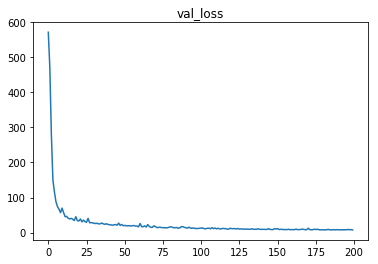

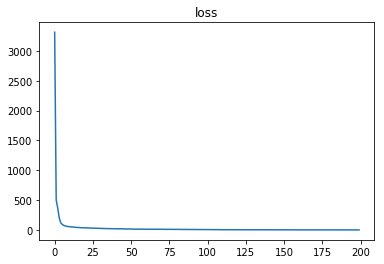

In [13]:
    #
    #   Show History
    #
    
    # load pickle
    print(dname_checkpoints + '/' + fname_history)
    history = pickle.load(open(dname_checkpoints + '/' + fname_history, 'rb'))
    
    from PIL import Image
    import matplotlib.pyplot as plt    
    
    for k in history.keys():
        plt.plot(history[k])
        plt.title(k)
        plt.show()